**Introduction**

Using the data provided we want to predict 3 to 4 years into the future the surface temperature of the south atlantic ocean. We will be using lagged regression and auto regression models.

**Source**

THe data is sourced from the class GitHub repository and was collected from https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview and is open sourced.

Below I am importing everything I need to do to create my visualizations including packages and the raw data from GitHub.

In [ ]:
!pip install pmdarima
!pip install prophet

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import AutoReg

In [ ]:
arctic = pd.read_csv('https://raw.githubusercontent.com/kikayjane/Climate/main/data/arctic.csv')
indian = pd.read_csv('https://raw.githubusercontent.com/kikayjane/Climate/main/data/indian.csv')
north_atlantic = pd.read_csv('https://raw.githubusercontent.com/kikayjane/Climate/main/data/north_atlantic.csv')
north_pacific = pd.read_csv('https://raw.githubusercontent.com/kikayjane/Climate/main/data/north_pacific.csv')
south_atlantic = pd.read_csv('https://raw.githubusercontent.com/kikayjane/Climate/main/data/south_atlantic.csv')
south_pacific = pd.read_csv('https://raw.githubusercontent.com/kikayjane/Climate/main/data/south_pacific.csv')
southern_seas = pd.read_csv('https://raw.githubusercontent.com/kikayjane/Climate/main/data/southern_seas.csv')

Below I am analyzing my data and getting rid of variables that may impact my graphs including errors in the time inputs. I am also renaming my variables to easier names for clarity.

In [ ]:
south_atlantic.head()

,sst,u10,hsig,time,latitude,longitude
0,295.14398,-2.858145,1.880945,1/1/40 12:00,-30.1,-16.1
1,295.19820,-10.065320,2.357849,1/2/40 12:00,-30.1,-16.1
2,295.24457,-4.187378,1.975307,1/3/40 12:00,-30.1,-16.1
3,295.29690,5.083636,1.438365,1/4/40 12:00,-30.1,-16.1
4,295.34857,-4.042992,1.379800,1/5/40 12:00,-30.1,-16.1


<ipython-input-11-1412ccc21ed1>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset['date'] = pd.to_datetime(dataset['date'], errors='coerce')
<ipython-input-11-1412ccc21ed1>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset['date'] = pd.to_datetime(dataset['date'], errors='coerce')
<ipython-input-11-1412ccc21ed1>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset['date'] = pd.to_datetime(dataset['date'], errors='coerce')
<ipython-input-11-1412ccc21ed1>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to

1974-01-01 12:00:00 2073-12-31 12:00:00


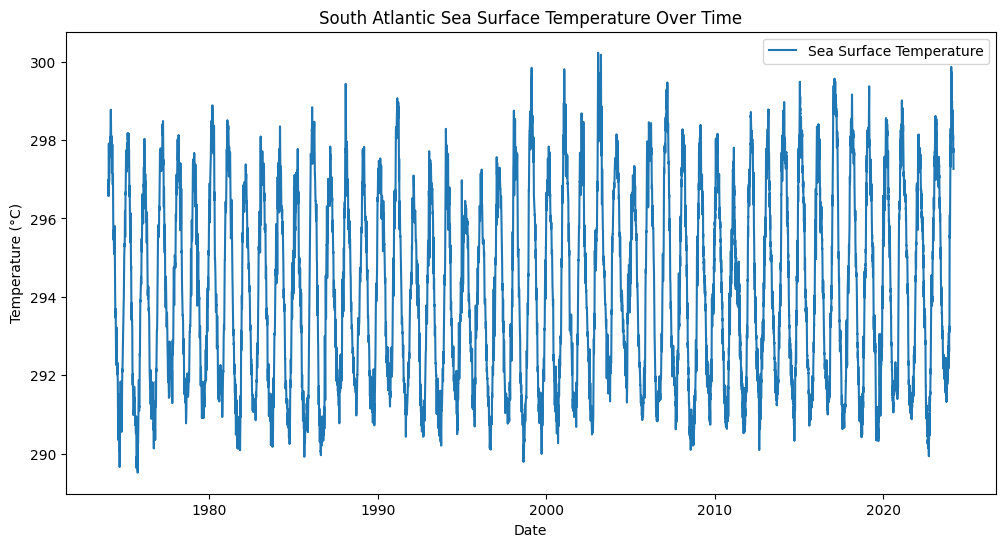

In [ ]:
# renaming variables for clarity
rename_dict = {"sst": "temperature", "u10": "speed", "hsig": "height", "time": "date"}

# group the datasets into one
datasets = [arctic, indian, north_atlantic, north_pacific, south_atlantic, south_pacific, southern_seas]

# rename columns for all datasets
for dataset in datasets:
    dataset.rename(columns=rename_dict, inplace=True)

# convert date columns to datetime
for dataset in datasets:
    dataset['date'] = pd.to_datetime(dataset['date'], errors='coerce')

# drop rows with parsing errors
for dataset in datasets:
    dataset.dropna(subset=['date'], inplace=True)

# set date as index for Sorth Atlantic dataset
south_atlantic.set_index('date', inplace=True)

# check the date range
print(south_atlantic.index.min(), south_atlantic.index.max())

# filter out any future dates beyond the current date
current_date = pd.Timestamp.now()
south_atlantic = south_atlantic[south_atlantic.index <= current_date]

# plot the South Atlantic surface temp
plt.figure(figsize=(12, 6))
plt.plot(south_atlantic['temperature'], label='Sea Surface Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('South Atlantic Sea Surface Temperature Over Time')
plt.legend()
plt.show()

Above shows the change in ocean surface temperature for the south atlantic ocean in degrees Kelvin

Below I am attempting to do a lagged regression of my south atlantic data using windspeed and surface temp

In [ ]:
surfacetemp = south_atlantic["sst"].values.reshape(-1, 1)
windspeed = south_atlantic["u10"].values.reshape(-1, 1)
time = np.arange(len(south_atlantic))

In [ ]:
# training data using a 3/4 split for South Atlantic data surface temp and wind speed data
k = 4

train_indices = list(range(3*len(south_atlantic) // 4))
test_indices = list(range(3*len(south_atlantic) // 4, len(south_atlantic)))

windspeed_train = windspeed[train_indices, :]
windspeed_test = windspeed[test_indices, :]
surfacetemp_train = surfacetemp[train_indices, :]
surfacetemp_test = surfacetemp[test_indices, :]


windspeed_lagged_train = windspeed_train[:-k, :]
windspeed_lagged_test = windspeed_test[:-k, :]
surfacetemp_lagged_train = surfacetemp_train[k:, :]
surfacetemp_lagged_test = surfacetemp_test[k:, :]


reg = LinearRegression().fit(windspeed_lagged_train, surfacetemp_lagged_train)
surfacetemp_predicted = reg.predict(windspeed_lagged_test)
mae = np.nanmean(np.abs(surfacetemp_predicted - surfacetemp_lagged_test))

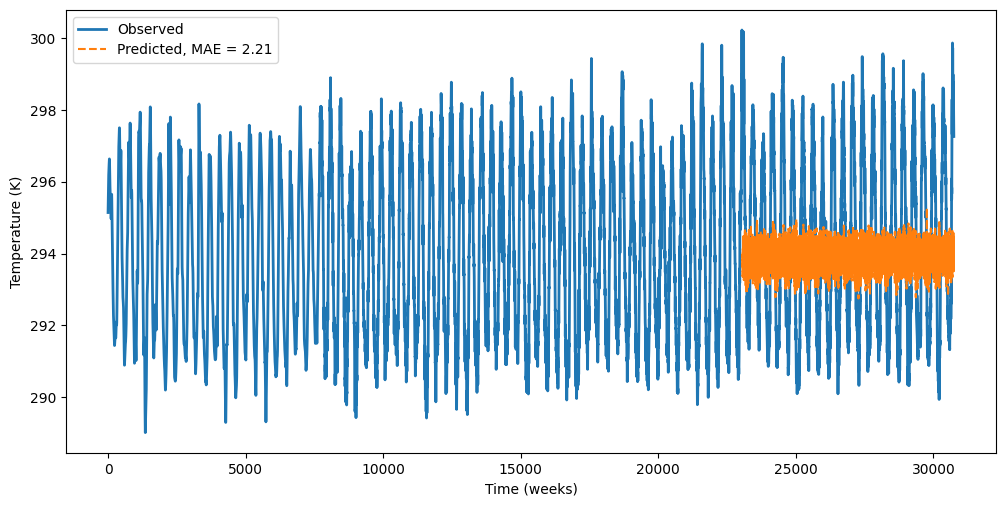

In [ ]:
#plotting the lagged regression
fig, ax = plt.subplots()
ax.plot(time, surfacetemp, '-', linewidth=2, label="Observed")
ax.plot(time[test_indices[k:]], surfacetemp_predicted, '--', label=f"Predicted, MAE = {mae:.2f}")
ax.legend()
ax.set_xlabel("Time (weeks)")
ax.set_ylabel("Temperature (K)")
fig.set_size_inches(10, 5)
fig.tight_layout(pad=0.5)
plt.show()

Below I am doing a autoregression to predict south atlantic surface temp 3-4 years into the future.

<ipython-input-18-7df566071469>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  south_atlantic['trend'] = result.trend
<ipython-input-18-7df566071469>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  south_atlantic['seasonal'] = result.seasonal
<ipython-input-18-7df566071469>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

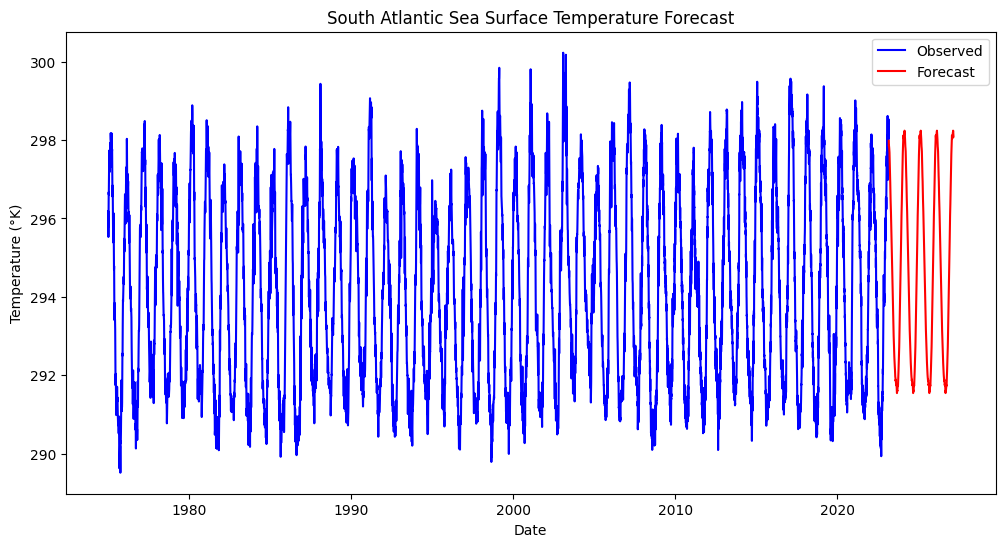

In [ ]:
# decompose
result = seasonal_decompose(south_atlantic['temperature'], model='additive', period=365)
south_atlantic['trend'] = result.trend
south_atlantic['seasonal'] = result.seasonal
south_atlantic['residual'] = result.resid

# drop NAN values created by decomposition
south_atlantic.dropna(inplace=True)

lags = 30
ar_model = AutoReg(south_atlantic['residual'], lags=lags).fit()

# forecast code
forecast_steps = 365 * 4  # forecasting for 4 years
forecast_residuals = ar_model.predict(start=len(south_atlantic), end=len(south_atlantic) + forecast_steps - 1, dynamic=False)
forecast_index = pd.date_range(start=south_atlantic.index[-1], periods=forecast_steps, freq='D')

last_trend = south_atlantic['trend'].iloc[-1]
last_seasonal = south_atlantic['seasonal'].iloc[-365:]
forecast_trend = np.linspace(last_trend, last_trend, forecast_steps)
forecast_seasonal = np.tile(last_seasonal, int(np.ceil(forecast_steps / 365)))[:forecast_steps]
forecast = forecast_residuals + forecast_trend + forecast_seasonal

# plot the forecasted south atlantic surface temp for 3-4 years
plt.figure(figsize=(12, 6))
plt.plot(south_atlantic.index, south_atlantic['temperature'], label='Observed', color='blue')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Temperature (°K)')
plt.title('South Atlantic Sea Surface Temperature Forecast')
plt.legend()
plt.show()